## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200"/>
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [2]:
# Check for NA values
train_data.isna().sum(axis=0)

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [3]:
# Drop ID values
train_data.drop(columns=["ID"], inplace=True)

# Examine each variable

Since control vs. treatment (exposure to and non-exposure to promotion) should be random, let's first check those two groups for balance.

In [4]:
train_data.groupby("Promotion").mean()

,purchase,V1,V2,V3,V4,V5,V6,V7
Promotion,,,,,,,,
No,0.007565,1.496277,29.976876,-0.007099,1.680270,2.330638,2.501565,1.702205
Yes,0.017019,1.505028,29.970338,0.007446,1.678949,2.324662,2.504225,1.701185


Next, we can examine the difference between purchasers and non-purchasers in each group (promo vs. nonpromo).

In [5]:
cols = ["V1", "V2", "V3", "V4", "V5", "V6", "V7"]

In [6]:
no_promo = train_data.loc[train_data["Promotion"]=="No"]
promo = train_data.loc[train_data["Promotion"]=="Yes"]

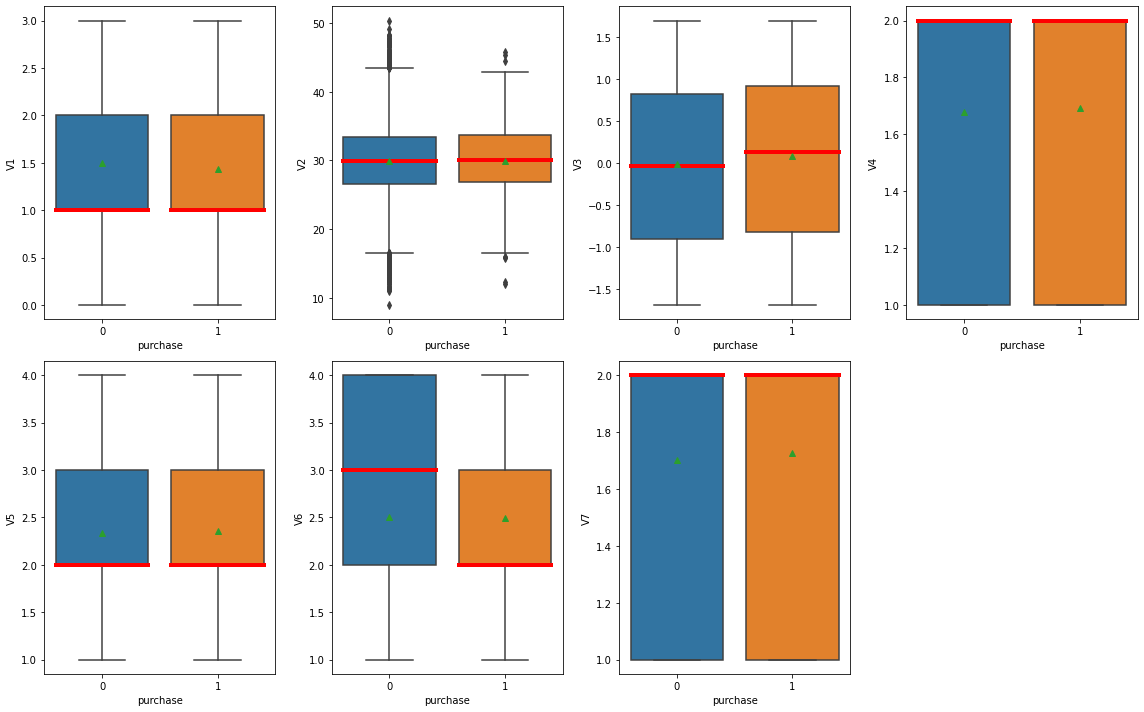

In [7]:
fig, ax = plt.subplots(2, 4, figsize=(16, 10))
sns.boxplot(y="V1", x="purchase", data=no_promo, ax=ax[0][0], showmeans=True, 
            medianprops=dict(linestyle='-', linewidth=4, color='r'))
sns.boxplot(y="V2", x="purchase", data=no_promo, ax=ax[0][1], showmeans=True,
           medianprops=dict(linestyle='-', linewidth=4, color='r'))
sns.boxplot(y="V3", x="purchase", data=no_promo, ax=ax[0][2], showmeans=True,
           medianprops=dict(linestyle='-', linewidth=4, color='r'))
sns.boxplot(y="V4", x="purchase", data=no_promo, ax=ax[0][3], showmeans=True, 
            medianprops=dict(linestyle='-', linewidth=4, color='r'))
sns.boxplot(y="V5", x="purchase", data=no_promo, ax=ax[1][0], showmeans=True,
           medianprops=dict(linestyle='-', linewidth=4, color='r'))
sns.boxplot(y="V6", x="purchase", data=no_promo, ax=ax[1][1], showmeans=True,
           medianprops=dict(linestyle='-', linewidth=4, color='r'))
sns.boxplot(y="V7", x="purchase", data=no_promo, ax=ax[1][2], showmeans=True,
           medianprops=dict(linestyle='-', linewidth=4, color='r'))
ax[1][3].axis('off')
fig.tight_layout()

* For V1, the users that chose to purchase have a slightly lower mean than those that didn't. The spread of the variables is about the same. For all purposes, there appears to be little difference.
* For V2, the users that chose to purchase have less extreme values; the spread of the V2 is smaller. However, the mean and median appear to be about the same - slightly higher for those that purchased.
* For V3, the users that chose to purchase have a higher mean and median. Overall the values of V3 for users that chose to purchase is greater in value than those that did not purchase - the distribution appears to be shifted upward.
* For V4, the mean for those that chose to purchase is slightly higher than those that did not, but the overall distribution of values is largely the same.
* For V5, the mean for those that chose to purchase is slightly higher than those that did not, but the overall distribution of values is largely the same.
* For V6, the distribution of users that chose to purchase is much different; the third quartile of users that didn't purchase is 4.0, while the third quartile of users that purchased is 3.0, which is the median of users that didn't purchase. The mean for users that purchased is slightly lower than the mean for those that did not.
* For V7, the distribution of values is the same, purchase or not; the mean of V7 is slightly higher for those that did purchase.

In [8]:
no_promo.groupby("purchase").mean()

,V1,V2,V3,V4,V5,V6,V7
purchase,,,,,,,
0,1.496738,29.976837,-0.007828,1.680175,2.330434,2.501661,1.702014
1,1.435737,29.982026,0.088530,1.692790,2.357367,2.489028,1.727273


In [9]:
no_promo.groupby("purchase").quantile([0, 0.25, 0.5, 0.75, 1])

/var/folders/5r/cdqskxq90vq3h884xj3nm3s80000gn/T/ipykernel_37370/1641418518.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  no_promo.groupby("purchase").quantile([0, 0.25, 0.5, 0.75, 1])


V1         V2        V3   V4   V5   V6   V7
purchase                                                   
0        0.00  0.0   8.939305 -1.684550  1.0  1.0  1.0  1.0
         0.25  1.0  26.608356 -0.905350  1.0  2.0  2.0  1.0
         0.50  1.0  29.969467 -0.039572  2.0  2.0  3.0  2.0
         0.75  2.0  33.352029  0.826206  2.0  3.0  4.0  2.0
         1.00  3.0  50.375913  1.691984  2.0  4.0  4.0  2.0
1        0.00  0.0  12.020592 -1.684550  1.0  1.0  1.0  1.0
         0.25  1.0  26.817853 -0.818772  1.0  2.0  2.0  1.0
         0.50  1.0  30.022216  0.133583  2.0  2.0  2.0  2.0
         0.75  2.0  33.767992  0.912784  2.0  3.0  3.0  2.0
         1.00  3.0  45.752533  1.691984  2.0  4.0  4.0  2.0

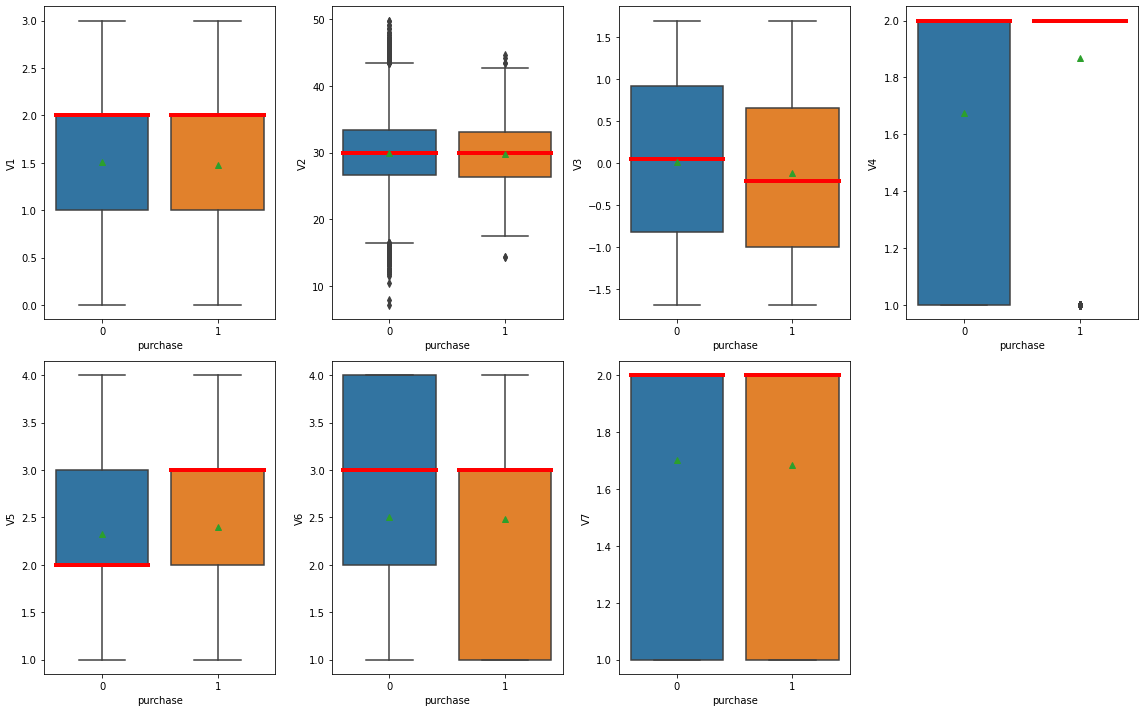

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(16, 10))
sns.boxplot(y="V1", x="purchase", data=promo, ax=ax[0][0], showmeans=True, 
            medianprops=dict(linestyle='-', linewidth=4, color='r'))
sns.boxplot(y="V2", x="purchase", data=promo, ax=ax[0][1], showmeans=True,
           medianprops=dict(linestyle='-', linewidth=4, color='r'))
sns.boxplot(y="V3", x="purchase", data=promo, ax=ax[0][2], showmeans=True,
           medianprops=dict(linestyle='-', linewidth=4, color='r'))
sns.boxplot(y="V4", x="purchase", data=promo, ax=ax[0][3], showmeans=True, 
            medianprops=dict(linestyle='-', linewidth=4, color='r'))
sns.boxplot(y="V5", x="purchase", data=promo, ax=ax[1][0], showmeans=True,
           medianprops=dict(linestyle='-', linewidth=4, color='r'))
sns.boxplot(y="V6", x="purchase", data=promo, ax=ax[1][1], showmeans=True,
           medianprops=dict(linestyle='-', linewidth=4, color='r'))
sns.boxplot(y="V7", x="purchase", data=promo, ax=ax[1][2], showmeans=True,
           medianprops=dict(linestyle='-', linewidth=4, color='r'))
ax[1][3].axis('off')
fig.tight_layout()

* For V1, the distribution of values is largely the same between purchase/no purchase. The mean is slightly lower for no purchase.
* For V2, the distribution of values is largely the same between purchase/no purchase. No purchase has more extreme values. The mean is slightly higher for no purchase.
* For V3, the distribution of values is lower for those that purchased. The median and mean are both lower for those that purchased.
* For V4, almost all users that purchased had a value of 2. 0.25 quantile is at 1 for those that didn't purchase, while 0.25 quantile is at 2 for those that did. The distribution of values is higher for those that purchased because of this. The mean is also higher for users that purchased because of this.
* For V5, the distribution is lower for users that did not purchase. The IQR is the same, but the median for non-purchasers is 2 while the median for purchasers is 3. Mean for purchasers is higher.
* For V6, the distribution is lower for users that did not purchase, but the distributions have relatively the same median and mean (mean is slightly lower for purchasers).
* For V7, the distribution is largely the same between purchase/no purchase. The mean for purchase is slightly lower.

In [11]:
promo.groupby("purchase").mean()

,V1,V2,V3,V4,V5,V6,V7
purchase,,,,,,,
0,1.505559,29.972246,0.009680,1.675672,2.323368,2.504527,1.701486
1,1.474341,29.860180,-0.121587,1.868239,2.399445,2.486824,1.683773


In [12]:
promo.groupby("purchase").quantile([0, 0.25, 0.5, 0.75, 1])

/var/folders/5r/cdqskxq90vq3h884xj3nm3s80000gn/T/ipykernel_37370/4182197472.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  promo.groupby("purchase").quantile([0, 0.25, 0.5, 0.75, 1])


V1         V2        V3   V4   V5   V6   V7
purchase                                                   
0        0.00  0.0   7.104007 -1.684550  1.0  1.0  1.0  1.0
         0.25  1.0  26.578229 -0.818772  1.0  2.0  2.0  1.0
         0.50  2.0  29.988669  0.047006  2.0  2.0  3.0  2.0
         0.75  2.0  33.339188  0.912784  2.0  3.0  4.0  2.0
         1.00  3.0  49.823708  1.691984  2.0  4.0  4.0  2.0
1        0.00  0.0  14.261619 -1.684550  1.0  1.0  1.0  1.0
         0.25  1.0  26.350912 -0.991928  2.0  2.0  1.0  1.0
         0.50  2.0  30.004793 -0.212728  2.0  3.0  3.0  2.0
         0.75  2.0  33.030562  0.653050  2.0  3.0  3.0  2.0
         1.00  3.0  44.719256  1.691984  2.0  4.0  4.0  2.0

# Promotion Strategy

I think we're ready to come up with a promotion strategy. We can use what we know about the users that were exposed to the promotion and who responded/didn't to decide who to send the promotion to. This primarily means using the data from promo exposed users and not from non-promo exposed users. However, since we are trying to decide how users will respond if we send the promo to them, examining how previous users who have received the promo have responded makes sense.

In [13]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    promotion = np.array(["Yes" for _ in range(df.shape[0])])
    # V1 and V7 distributions are basically the same, so no rules for these variables
    # V5 distribution is slightly different, but IQR is basically the same, so no rule
    
    # For V2, exclude extreme values
    promotion[np.where(df["V2"] > 45)] = "No"
    promotion[np.where(df["V2"] < 12)] = "No"
    
    # For V3, exclude users that had above the mean purchase value
    # Because the purchase median for V3 is below the mean purchase value
    # and the mean nonpurchase is above the mean purchase value, this will
    # exclude a larger proportion of nonpurchasers.
    promotion[np.where(df["V3"] > -0.12)] = "No"
    
    # For V4, only include users with V4 == 2
    promotion[np.where(df["V4"] != 2)] = "No"
    
    # For V6, exclude values above the 0.75 percentile of purchasers
    promotion[np.where(df["V6"] > 3)] = "No"
    
    return promotion

In [14]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0216.

Your nir with this strategy is 332.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.021554860428509348, 332.20000000000005)